# Telegram Group Chat analysis

I've often felt I was the most talkative among my closest friends. Since I'm a scientist, I decided to put this to the test using a few Data Science techniques. The results I found were pretty Interesting

In [1]:
import utils
import json
import pandas as pd
import string
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt
import plotly.express as px
from datetime import datetime
import urllib.parse
import numpy as np
import re
import seaborn as sns
from itertools import groupby
from nltk.util import ngrams
import collections
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

###### Telegram allows you to download your personal chat history in json format. I won't be sharing mine for obvious reasons, but this notebook should be easily applicable to your personal / group chat data.

In [2]:
#loading up the result.json data file just as it was provided by Telegram
data_file= 'data/terapia_de_grupo/result.json'

with open(data_file) as json_file:
    data = json.load(json_file)

## EDA

In [3]:
data.keys()

dict_keys(['name', 'type', 'id', 'messages'])

In [4]:
data['type']

'private_group'

In [5]:
data['name']

'Terapia de grupo'

In [6]:
# now, let's see how many messages we've got, then...
len(data['messages'])

22732

###### For obvious reasons I've obfuscated `from` and `from_id`

In [7]:
# then let's see what a message looks like
data['messages'][:3]

[{'id': 9369,
  'type': 'service',
  'date': '2018-02-24T10:44:08',
  'actor': 'Alice',
  'actor_id': 1,
  'action': 'create_group',
  'title': 'Terapia de grupo',
  'members': ['Alice', 'Bob', 'Trudy'],
  'text': ''},
 {'id': 9370,
  'type': 'message',
  'date': '2018-02-24T10:44:15',
  'from': 'Alice',
  'from_id': 1,
  'file': 'stickers/sticker.webp',
  'thumbnail': 'stickers/sticker.webp_thumb.jpg',
  'media_type': 'sticker',
  'sticker_emoji': '💝',
  'width': 512,
  'height': 512,
  'text': ''},
 {'id': 9371,
  'type': 'message',
  'date': '2018-02-24T10:44:25',
  'from': 'Trudy',
  'from_id': 3,
  'text': 'Jajajaja'}]

#### At a glance this seems to be a pretty simple structure:

* Some messages might have an `action`, like that first element that identifies the `create_group` action
* Messages have an `actor` and it's associated `actor_id`
* There's an `id` that's correlative to my personal messages (yeah, I've checked: I've got 9000 accumulated messages previous to the creation of this group)
* We are interested in the messages that have `type` equal to `message`, and within those we are interested in the `text` field
* We might also consider those which have `media_type` since they might provide insight on the kind of emotes my friends use
* There might be some other message types, like `thumbnail` and `link`, so we'll need some further exploration

#### Moving on...

In [8]:
# loading `messages` to a DataFrame
df= pd.DataFrame(data['messages'])
df.sample(5)

,id,type,date,actor,actor_id,action,title,members,text,from,...,width,height,mime_type,duration_seconds,via_bot,photo,reply_to_message_id,forwarded_from,message_id,edited
19111,35011,message,2020-06-24T16:01:27,NaN,NaN,NaN,NaN,NaN,si todo se va al choto no tenés protección leg...,Alice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
376,12577,message,2019-06-04T14:35:07,NaN,NaN,NaN,NaN,NaN,"Ok, here it goes... \n\n The two-foot long bir...",bot,...,NaN,NaN,NaN,NaN,NaN,NaN,12576.0,NaN,NaN,NaN
12327,27875,message,2020-05-13T18:59:41,NaN,NaN,NaN,NaN,NaN,that would be cool,Alice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
280,12471,message,2019-05-31T19:52:24,NaN,NaN,NaN,NaN,NaN,Jijiji,Alice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13752,29309,message,2020-05-24T19:56:54,NaN,NaN,NaN,NaN,NaN,bueeeno,Bob,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### But upon further analysis, we can see the message structure is not that trivial

In [9]:
df.keys()

Index(['id', 'type', 'date', 'actor', 'actor_id', 'action', 'title', 'members',
       'text', 'from', 'from_id', 'file', 'thumbnail', 'media_type',
       'sticker_emoji', 'width', 'height', 'mime_type', 'duration_seconds',
       'via_bot', 'photo', 'reply_to_message_id', 'forwarded_from',
       'message_id', 'edited'],
      dtype='object')

##### Apparently there are only two types of message
* `service`
* `message`

In [10]:
df['type'].unique()

array(['service', 'message'], dtype=object)

##### In case you are curious about those tagged `service` 

In [11]:
df.loc[df['type']=='service']

,id,type,date,actor,actor_id,action,title,members,text,from,...,width,height,mime_type,duration_seconds,via_bot,photo,reply_to_message_id,forwarded_from,message_id,edited
0,9369,service,2018-02-24T10:44:08,Alice,1.0,create_group,Terapia de grupo,"[Alice, Bob, Trudy]",,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,9425,service,2018-02-24T23:00:55,Bob,2.0,edit_group_photo,NaN,NaN,,NaN,...,640.0,640.0,NaN,NaN,NaN,photos/photo_3@24-02-2018_23-00-55.jpg,NaN,NaN,NaN,NaN
141,12248,service,2019-05-24T20:49:16,Bob,2.0,invite_members,NaN,[bot],,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1265,15719,service,2020-02-21T09:16:57,Bob,2.0,pin_message,NaN,NaN,,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15717.0,NaN
1300,15754,service,2020-02-21T09:37:53,Bob,2.0,remove_members,NaN,[bot],,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1307,15761,service,2020-02-21T10:19:56,Alice,1.0,invite_members,NaN,[Eve],,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2675,17269,service,2020-03-03T23:27:49,Bob,2.0,invite_members,NaN,[Book Download Bot],,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2694,17290,service,2020-03-03T23:30:05,Bob,2.0,remove_members,NaN,[Book Download Bot],,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14741,30299,service,2020-05-29T00:54:00,Bob,2.0,invite_members,NaN,[Book Download Bot],,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14742,30300,service,2020-05-29T00:55:06,Bob,2.0,remove_members,NaN,[Book Download Bot],,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### The only two actors who have run `service` actions were Alice and Bob

In [12]:
df.loc[df['type']=='service']['actor'].unique()

array(['Alice', 'Bob'], dtype=object)

#### I'm only interested in the proper messages (not the actions)... let's see if we can get some insights

In [13]:
msg_df= df.loc[df['type']=='message']
msg_df.sample(5)

,id,type,date,actor,actor_id,action,title,members,text,from,...,width,height,mime_type,duration_seconds,via_bot,photo,reply_to_message_id,forwarded_from,message_id,edited
5412,20748,message,2020-03-24T19:23:32,NaN,NaN,NaN,NaN,NaN,jajaja,Alice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3759,18906,message,2020-03-15T18:08:13,NaN,NaN,NaN,NaN,NaN,:-3 que miedo el mundo que se viene...,Bob,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9407,24811,message,2020-04-22T10:50:40,NaN,NaN,NaN,NaN,NaN,Ok,Alice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17949,33837,message,2020-06-17T12:52:11,NaN,NaN,NaN,NaN,NaN,En inglés acento un poco British,Alice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6115,21462,message,2020-03-28T21:05:00,NaN,NaN,NaN,NaN,NaN,it´s a book joke,Alice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Seems the DataFrame is pretty sparse... counting should make things easier. We've got over 22k `text` messages. That is A LOT! We'll have to come back to further explore this

In [14]:
message_count=msg_df.count()
message_count=message_count[message_count != 0] # filter out zero values
message_count['text']

22722

### First we'll be taking a closer look at the non-text-based message count

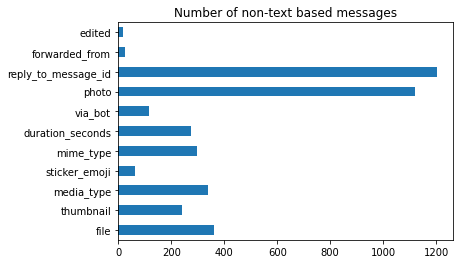

In [15]:
#dropping `text` messages and other columns that don't show interesting information
message_count_plot= message_count.drop(labels=['id','type','text','from','from_id','date','height','width'])
message_count_plot.plot.barh(title='Number of non-text based messages');

#### Some observations:
* We don't edit many of our messages after being sent
* We don't ussually forward messages
* We reply a lot of messages!
* We share a lot of images!
* We have a couple of bots
* The total amount of time in audio messages is relatively short
* We don't usually send a single emoji as a message
* We've shared over 300 files

In [16]:
#some pandas-fu to create a df with the indexed dates for the replies
reply_df= msg_df[['date','reply_to_message_id','from']].dropna()
reply_df= pd.merge(reply_df.rename(columns={'reply_to_message_id': 'id'}),
        df[['reply_to_message_id','id','date']],
        on='id').rename(columns={'date_x': 'reply','date_y':'orig_msg'})[['reply','from','orig_msg']]
reply_df['delta']=pd.to_datetime(reply_df['reply']) - pd.to_datetime(reply_df['orig_msg']) #calculating the time delta

#### Let's plot each participant's delta time for replying.

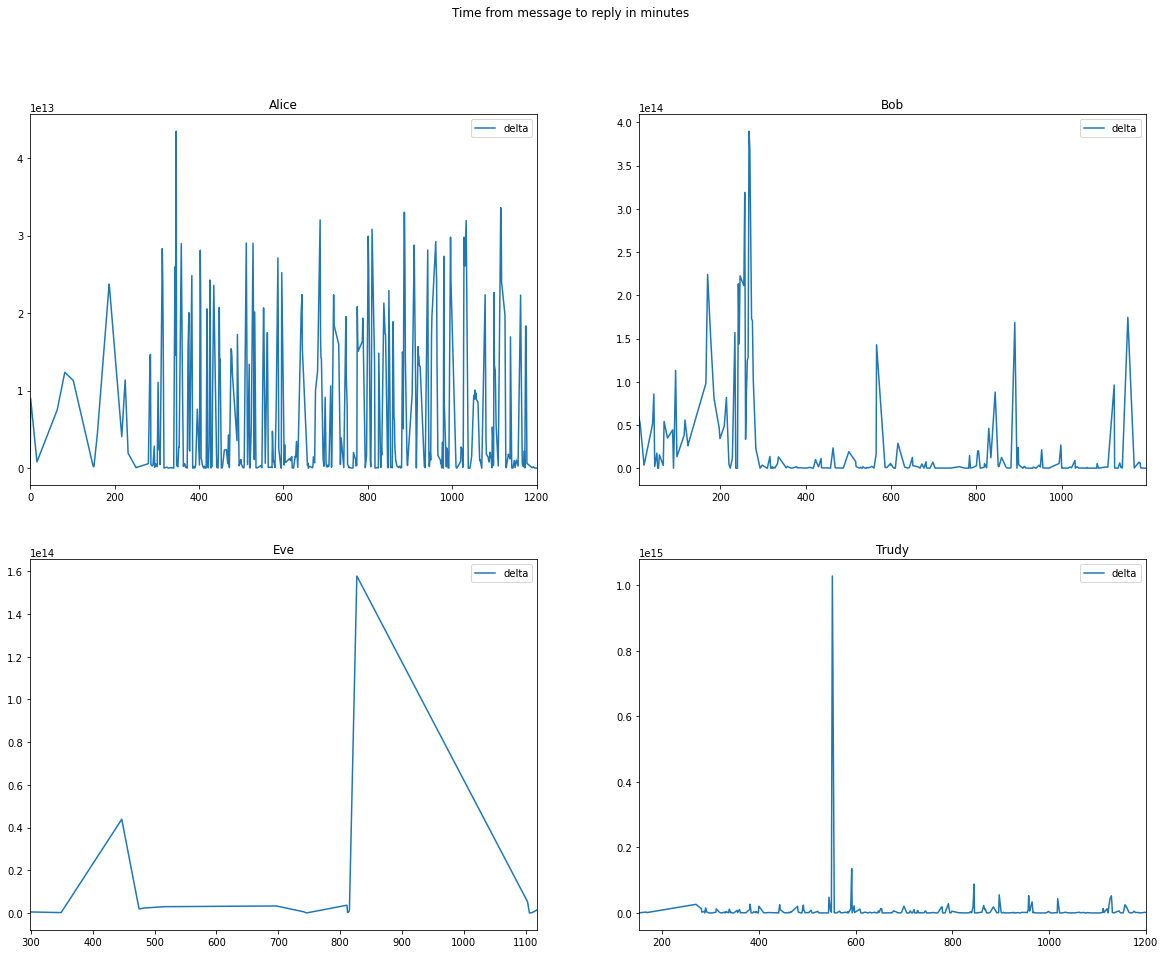

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
reply_df.loc[reply_df['from']=='Alice'].plot(ax=axes[0,0],
        y='delta',title='Alice'); axes[0,0].set_title('Alice')
reply_df.loc[reply_df['from']=='Bob'].plot(ax=axes[0,1],
        y='delta',title='Bob'); axes[0,1].set_title('Bob')
reply_df.loc[reply_df['from']=='Eve'].plot(ax=axes[1,0],
        y='delta',title='Eve'); axes[1,0].set_title('Eve')
reply_df.loc[reply_df['from']=='Trudy'].plot(ax=axes[1,1],
        y='delta',title='Trudy'); axes[1,1].set_title('Trudy')
fig.suptitle('Time from message to reply in minutes')
plt.show();

##### Apparently:
* `Alice` replies a lot, but takes several minutes to do so
* `Bob` has some seasonality, meaning every now and then he'll take his time
* `Trudy` doesn't take much time to reply, for the most part
* `Eve` doesn't reply much

###### I forgot about the bot, but I don't expect much, since it's supposed to respond immediately

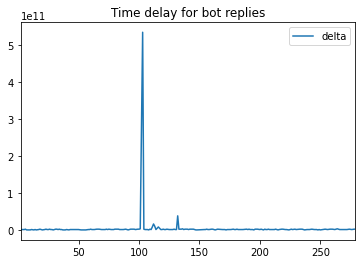

In [18]:
reply_df.loc[reply_df['from']=='bot'].plot(y='delta',title='Time delay for bot replies');

###### Woah! Another unexpected insight: at some point the bot had an issue and `delta` went up

### Let's move on to the next feature... Images!

##### Apparently, Telegram embeds the date on the file-name... kind of redundant if you ask me (?)

In [19]:
images_df= msg_df[['date','photo','from']].dropna()
images_df.sample(5)

,date,photo,from
11367,2020-05-05T17:45:24,photos/photo_595@05-05-2020_17-45-24.jpg,Bob
12392,2020-05-14T01:31:58,photos/photo_640@14-05-2020_01-31-58.jpg,Bob
9124,2020-04-19T14:34:12,photos/photo_479@19-04-2020_14-34-12.jpg,Bob
5757,2020-03-26T16:26:06,photos/photo_297@26-03-2020_16-26-06.jpg,Bob
11309,2020-05-05T12:51:20,photos/photo_592@05-05-2020_12-51-20.jpg,Bob


#### Counting the images sent by group member and...Well, well, well! It would seem like Bob is a pretty visual guy... 

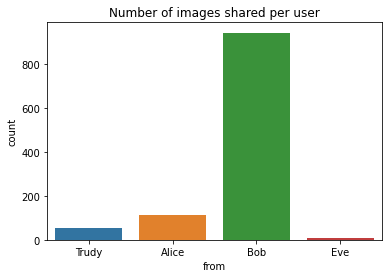

In [20]:
sns.countplot(x='from', data=images_df)
plt.title('Number of images shared per user');

#### Let's see the actual distribution of images sent by Bob over time

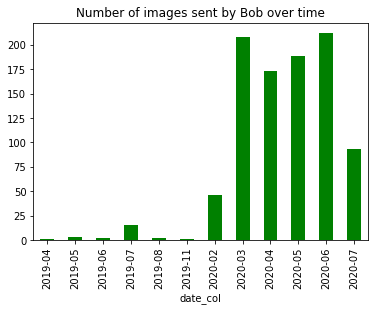

In [21]:
bobs_images_sent= images_df.loc[images_df['from']=='Bob']
bobs_images_sent['date_col'] = pd.to_datetime(bobs_images_sent['date'], utc=True)
bobs_images_sent.reset_index().set_index('date_col')
bobs_images_sent.set_index('date_col')
bobs_images_sent= bobs_images_sent['date_col'].groupby(
    bobs_images_sent.date_col.dt.to_period("M")).agg('count')
bobs_images_sent.plot.bar(color='g',title='Number of images sent by Bob over time');

###### Looks like Bob started sending lots of images in February 2020.

## What about files? We've shared over 350 files over the past two years, that sounds like a lot

In [22]:
file_df= df[['date','file','from']].dropna()
file_df

,date,file,from
1,2018-02-24T10:44:15,stickers/sticker.webp,Alice
4,2018-02-24T10:44:57,stickers/sticker (1).webp,Alice
6,2018-02-24T10:46:19,video_files/animation.gif.mp4,Alice
8,2018-02-24T10:47:14,video_files/giphy.mp4,Alice
15,2018-02-24T10:49:02,video_files/giphy (1).mp4,Trudy
...,...,...,...
22288,2020-07-10T09:18:22,stickers/sticker (46).webp,Alice
22315,2020-07-10T12:29:20,video_files/mp4 (28).mp4,Bob
22316,2020-07-10T12:31:15,video_files/animation (26).gif.mp4,Alice
22671,2020-07-11T10:48:13,video_files/mp4 (29).mp4,Bob


#### Oh... now I get it! At a glance, most of the files are gif and animations... that makes sense, right?
##### Let's explore this a bit further

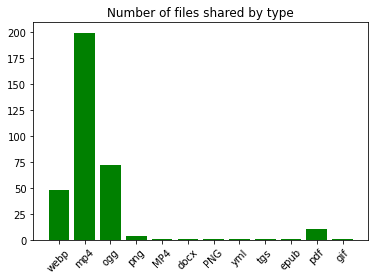

In [23]:
files_sent=file_df['file'].unique()
file_types=defaultdict(int)
for f in files_sent:
    file_types[f.split('.')[-1]]+=1

plt.bar(list(file_types.keys()),file_types.values(), color='g')
plt.title('Number of files shared by type')
plt.xticks(rotation=45)
plt.show();

##### That was unexpected... there are a lot of audio files `.ogg` that I was not considering.

#### Still... The majority of the files shared were animations and audio files, let's see who's been the most active sharing files

In [24]:
# create a column with the file extension so we can filter out who sends more of each type of files
tmp2_file_df=file_df[['file','from']]
tmp2_file_df= tmp2_file_df.file.str.split('.',expand=True)
tmp2_file_df['extension']=tmp2_file_df[2].fillna(tmp2_file_df[1])
ext_df= file_df[['date','from','file']].join(tmp2_file_df['extension'])
#ext_df

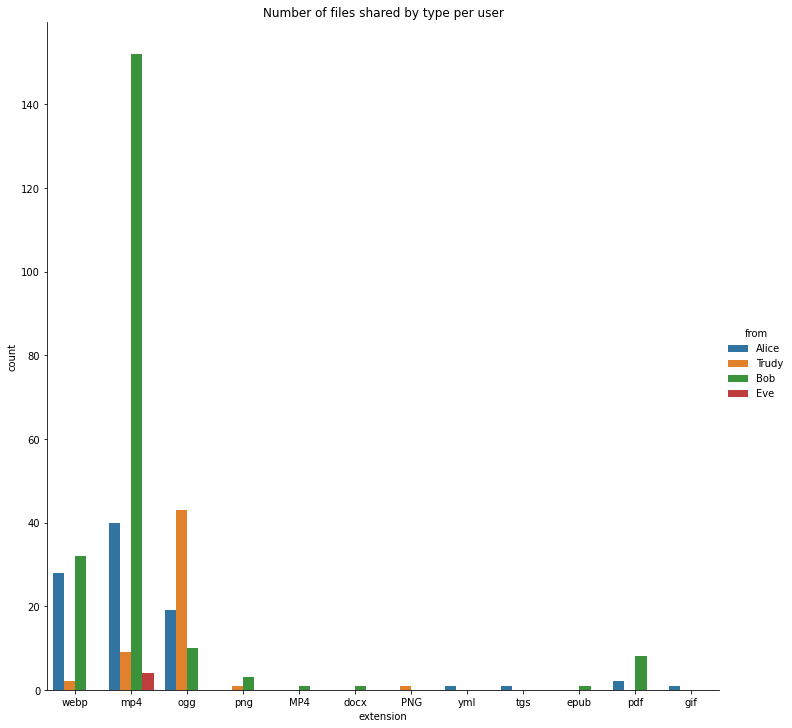

In [25]:
#plotting the distribution of files sent by each group member
g = sns.catplot(x="extension", hue="from",
                data=ext_df, kind="count",
                height=10)
plt.title('Number of files shared by type per user');

###### Once again, Bob proves he is the most visual member of the group by sending too many animations. One interesting find is that Trudy appears to be the most vocal member of the group, sending the most `.ogg` audio messages!

## Moving on to Emojis!

###### In Telegram, when you send a single emoji as a message or reply, it is displayed bigger and sometimes even animated. Let's analyze those solo-emoji messages. There's not much information to work with, but let's analyze it's distribution

In [26]:
solo_emoji_df= msg_df[['sticker_emoji','from']].dropna()
solo_emoji_df['sticker_emoji'].count()

62

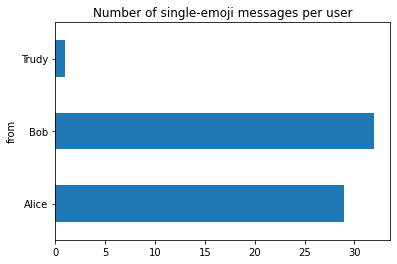

In [27]:
solo_emoji_df.groupby('from')['sticker_emoji'].count().plot.barh()
plt.title('Number of single-emoji messages per user');

In [28]:
# setting up a few pd.Series to count each member's single-emoji messages
solo_emoji_df=msg_df[['sticker_emoji','from']].dropna()
#alice
alice_solo_emoji= solo_emoji_df.loc[solo_emoji_df['from']=='Alice']
alice_solo_emoji_count= alice_solo_emoji.groupby('sticker_emoji')['from'].count()
#bob
bob_solo_emoji= solo_emoji_df.loc[solo_emoji_df['from']=='Bob']
bob_solo_emoji_count= bob_solo_emoji.groupby('sticker_emoji')['from'].count()
#trudy
trudy_solo_emoji= solo_emoji_df.loc[solo_emoji_df['from']=='Trudy']
trudy_solo_emoji_count= trudy_solo_emoji.groupby('sticker_emoji')['from'].count()
#eve
eve_solo_emoji= solo_emoji_df.loc[solo_emoji_df['from']=='Eve']
eve_solo_emoji_count= eve_solo_emoji.groupby('sticker_emoji')['from'].count()

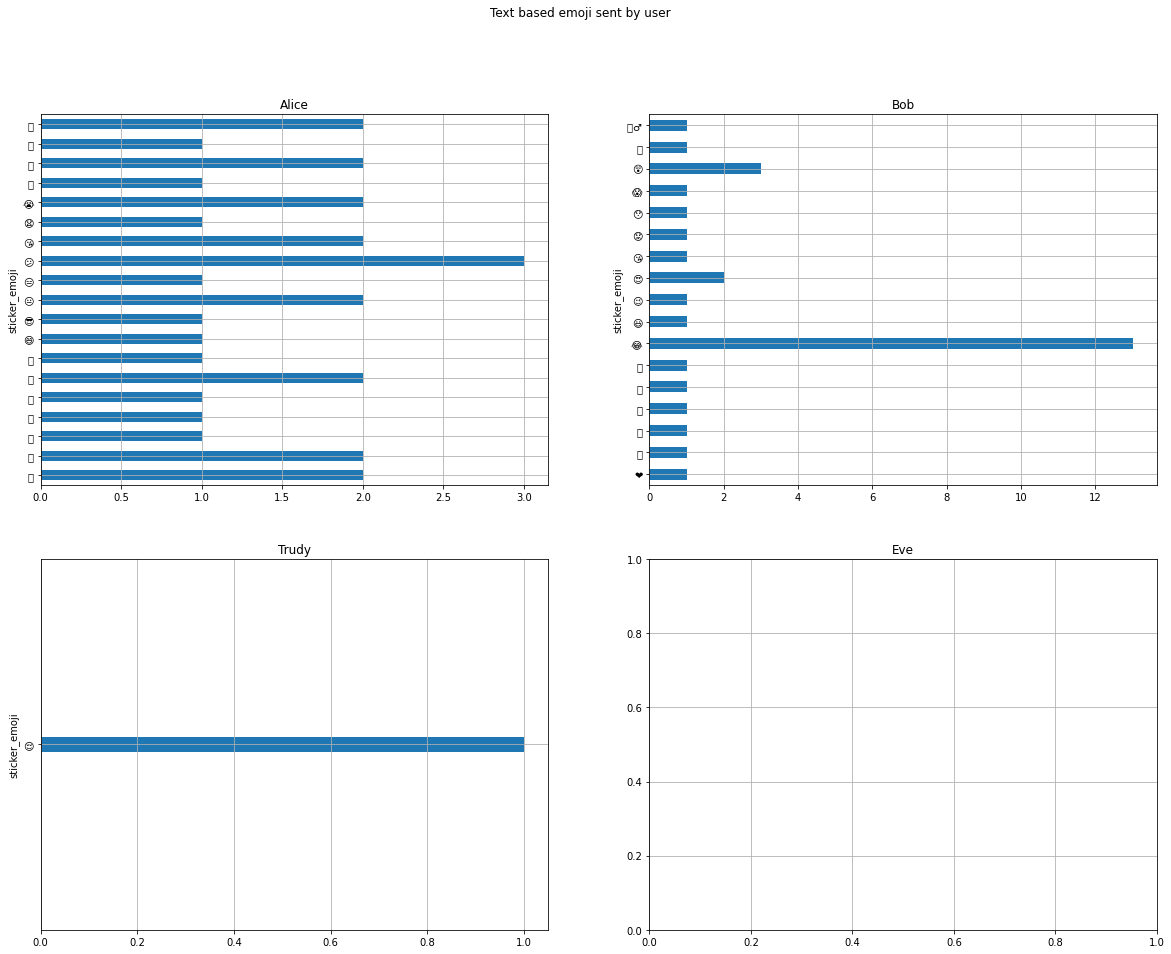

In [29]:
# plot 2x2
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
alice_solo_emoji_count.plot.barh(ax=axes[0,0],
        y='delta',title='Alice'); axes[0,0].set_title('Alice')
bob_solo_emoji_count.plot.barh(ax=axes[0,1],
        y='delta',title='Bob'); axes[0,1].set_title('Bob')
trudy_solo_emoji_count.plot.barh(ax=axes[1,0],
        y='delta',title='Trudy',width=0.02); axes[1,0].set_title('Trudy')
#eve_solo_emoji_count.plot.barh(ax=axes[1,1],
#        y='delta',title='Eve');
# Eve didn't send any single-emoji messages
axes[1,1].set_title('Eve')
axes[0,0].grid()
axes[0,1].grid()
axes[1,0].grid()
axes[1,1].grid()
fig.suptitle('Text based emoji sent by user');
plt.show();

#### Well... once again, Bob is leading the charts with the amount of messages containing a single 😂 he sends. However, we've discovered that Alice appears to have a broader lexicon when it comes to emojis!

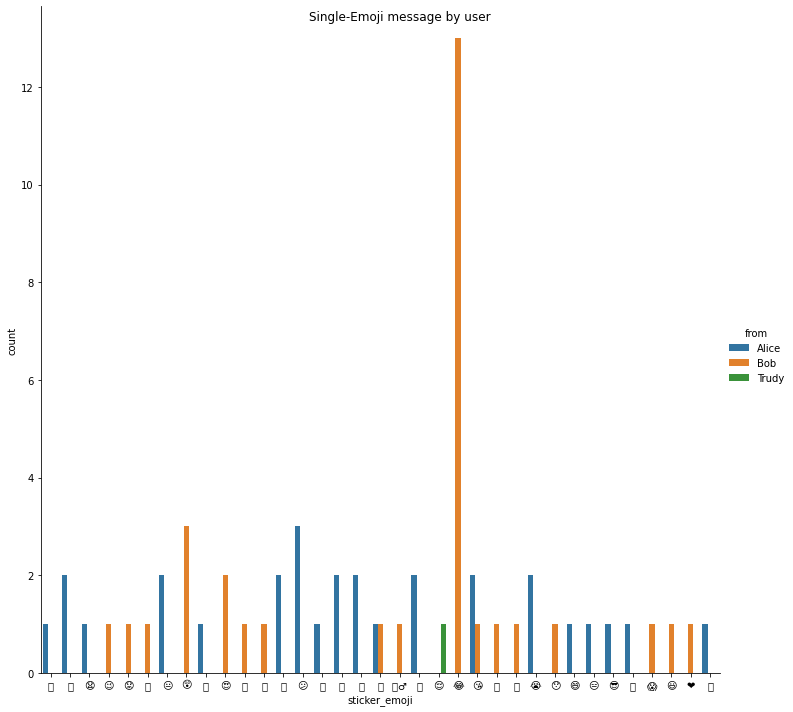

In [30]:
# plotting them all side by side for comparison
g = sns.catplot(x="sticker_emoji", hue="from",
                data=solo_emoji_df, kind="count",
                height=10,orient='h')
g.fig.suptitle('Single-Emoji message by user');

#### Either Bob is a jolly fellow or the other group members are very funny 😂

###### To further research this subject, we're going to have to dive deep into the `text` based messages and analyze the emojis within

## Let's look into those 22k text messages

In [31]:
# we're gonna be working with a text dataframe
text_df= msg_df[['date','from','text']]
text_df['text'].replace('', np.nan, inplace=True) # replace empty strings with NaN
text_df.dropna(subset=['text'], inplace=True) #drop NaN

#### Some data cleaning...

In [32]:
# a customized subset from nltk.stopwords('spanish')
stopwords=utils.stopwords
one_grams=[]
weird_one_grams=[]
non_string_messages=[]
for msg in text_df['text']:
    if isinstance(msg,str):
        msg_1gram,weird_gram = utils.process_msg(msg)
        one_grams.extend(msg_1gram)
        weird_one_grams.extend(weird_gram)
    else:
        non_string_messages.append(msg)

#show an example of the results
one_grams[1],weird_one_grams[1]

('great', '...')

In [33]:
# let's see how many n-grams I got and how many weird words
len(one_grams),len(weird_one_grams)

(69263, 11734)

###### Looks like I've got a lot of weird words that got cought by `weird_one_grams`. I'll have to come back to look into those typos and failed words

#### I just want to plot the ones that got parsed correctly to get an idea on which proper words are most used by me and my friends

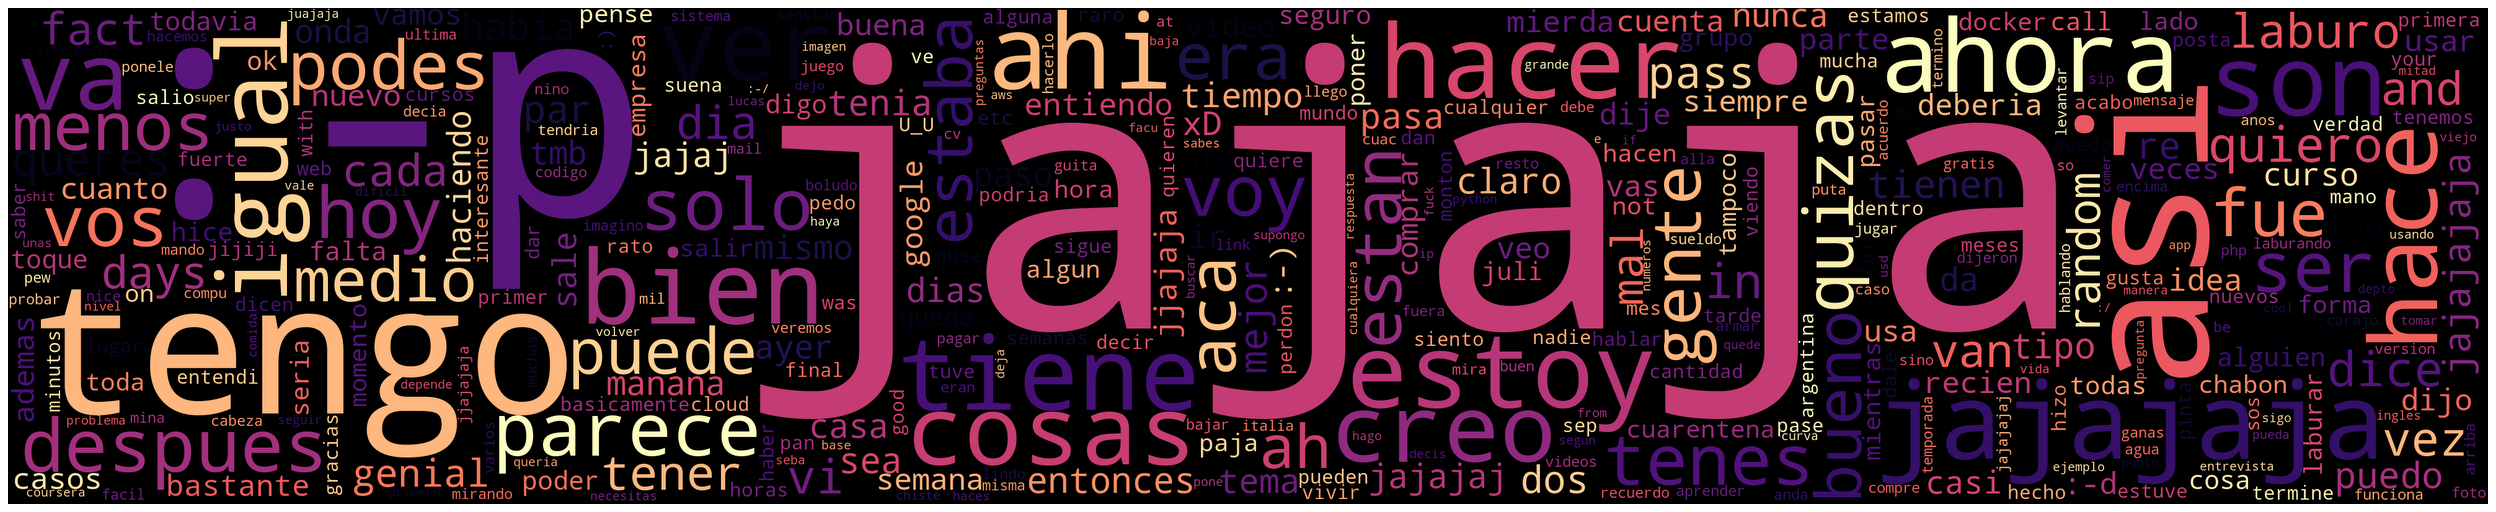

In [34]:
# Show a word cloud for the most used words
word_freq= defaultdict(int)
for word in one_grams:
    word_freq[word]+=1

wc = WordCloud(width = 4000, height = 800,
               min_font_size=10,max_words=400,
              mode='RGBA',colormap='magma',
              min_word_length=2).generate_from_frequencies(word_freq)
#wc.to_file('words.png')
plt.figure(figsize=(40, 30), dpi= 80, edgecolor='k')
plt.imshow(wc, interpolation="lanczos")
plt.axis("off")
plt.show()

#### It would seem the most common word is `jajaja`, the laughing onomatopoeia for Spanish, followed by the tongue emoji in it's text form `:-p`

In [35]:
# filter the one_grams that appear in emoji
emojis=[word for word in one_grams if word in utils.emoj]
# create an emoji counter
emoji_freq= defaultdict(int)
for em in emojis:
    emoji_freq[em]+=1
emoji_sorted_key,emoji_sorted_value= zip(* sorted(
        emoji_freq.items(), key=lambda item: item[1]))

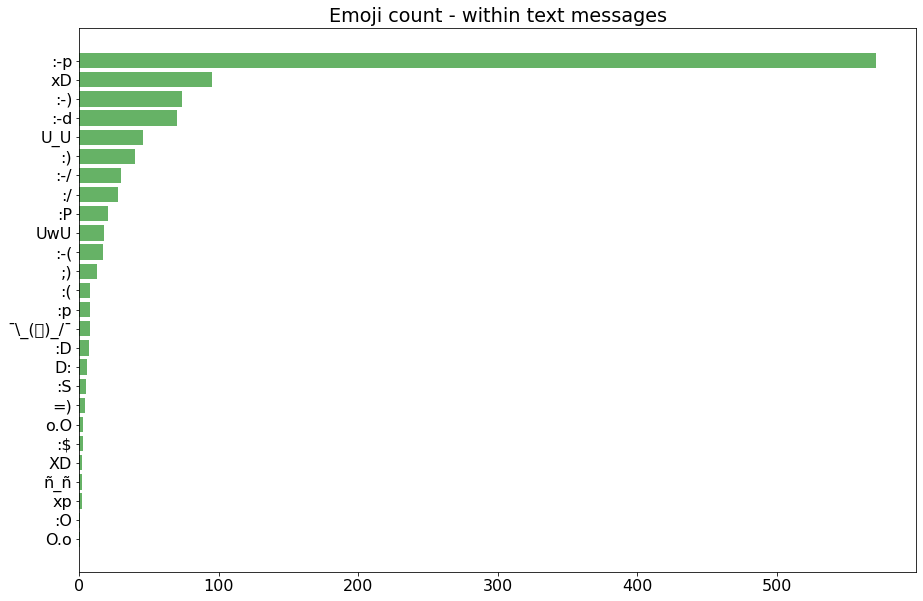

In [36]:
plt.figure(figsize=(15, 10))
plt.rcParams['font.size']=16
plt.title('Emoji count - within text messages')
plt.barh(emoji_sorted_key, emoji_sorted_value, color='g',alpha=0.6);

### We've got a pretty diverse emoji vocabulary... but what about the most repeated phrases?

In [37]:
# I'm leaving out the bot and counting in the stopwords for this part
one_grams_withStop=[]
weird_one_grams_withStop=[]
non_string_messages_withStop=[]
for msg in text_df.loc[text_df['from'] != 'bot']['text']:
    if isinstance(msg,str):
        msg_1gram,weird_gram = utils.process_msg(msg,False,True)
        one_grams_withStop.extend(msg_1gram)
        weird_one_grams_withStop.extend(weird_gram)
    else:
        non_string_messages_withStop.append(msg)

#### Taking a closer look at the 4-word ngram, we can see the most usual 4 word sentence is explanatory ("the issue is that...")

In [38]:
msg4Grams_withStop = ngrams(one_grams_withStop, 4)
fourGramFreq_withStop = collections.Counter(msg4Grams_withStop)
top4gram= fourGramFreq_withStop.most_common(6)
top4gram

[(('el', 'tema', 'es', 'que'), 21),
 (('no', 'se', 'si', 'es'), 12),
 (('un', 'par', 'de', 'dias'), 11),
 (('un', 'par', 'de', 'cosas'), 9),
 (('de', 'las', 'cosas', 'que'), 8),
 (('la', 'idea', 'es', 'que'), 8)]

#### If we check the 3-word ngram, by far the most usual sentence translates as "a couple of"

In [39]:
msg3Grams_withStop = ngrams(one_grams_withStop, 3)
threeGramFreq_withStop = collections.Counter(msg3Grams_withStop)
top3gram= threeGramFreq_withStop.most_common(6)
top3gram

[(('un', 'par', 'de'), 105),
 (('o', 'algo', 'asi'), 47),
 (('de', 'lo', 'que'), 42),
 (('no', 'se', 'si'), 41),
 (('el', 'tema', 'es'), 37),
 (('tema', 'es', 'que'), 33)]

### Lets take a walk through time

In [40]:
# declare df
user_msg_df= text_df.loc[text_df['from'] != 'bot']
user_msg_df= user_msg_df.loc[text_df['from'] != 'Book Download Bot']
# convert date to utc
user_msg_df['date']=pd.to_datetime(user_msg_df['date'], utc=True)
# normalizing text as text
user_msg_df['text']=user_msg_df['text'].astype(str)

#### Plotting the amount of messages per user through the day

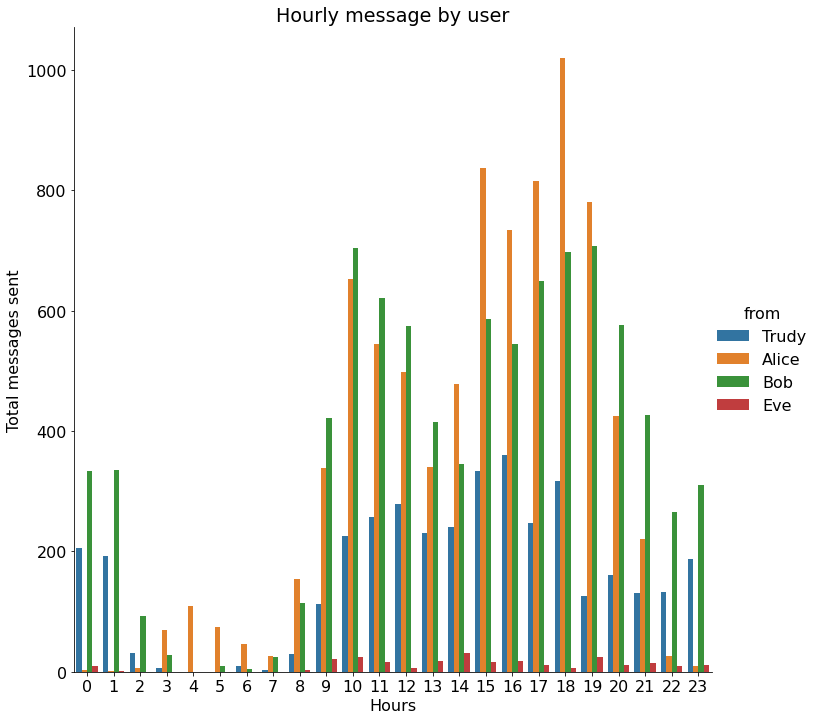

In [41]:
# Thanks to Karina Bartolome and Fabricio Previgliano for this df transition
user_msg_df['hour']=user_msg_df['date'].dt.to_period("H")
user_msg_df['hour']=user_msg_df['hour'].dt.hour
user_msg_df.groupby(['from', 'hour'],as_index=False).agg('count')

g = sns.catplot(x='hour', hue="from",
                data=user_msg_df[['from','text','hour']], kind="count",
                height=10,orient='h')
g.set(xlabel="Hours", ylabel = "Total messages sent")
plt.title('Hourly message by user');

###### We see a couple of trends here:
* Alice sends more messages in the afternoon
* Bob sends more messages around 10 am and 7 pm
* Trudy is pretty constant with the amount of messages he sends through the day
* Finally, it is clear that Eve doesn't talk much

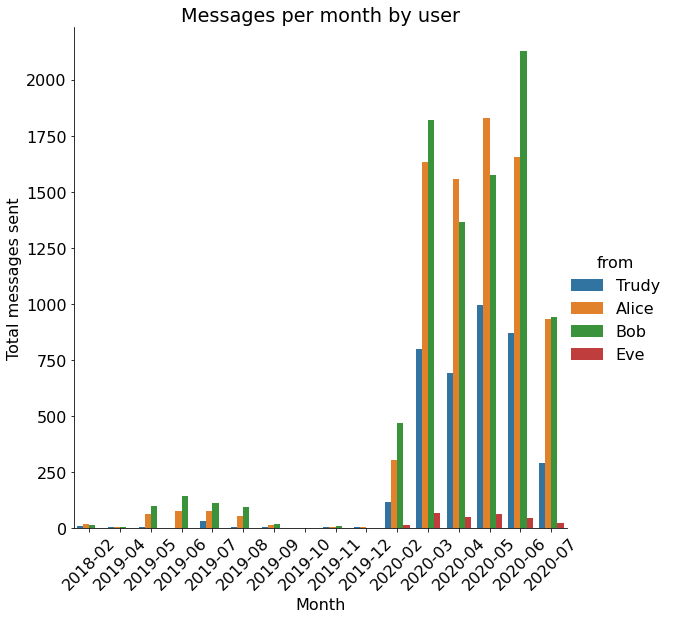

In [42]:
user_msg_df['month']=user_msg_df['date'].dt.to_period("M")
user_msg_df.groupby(['from', 'month'],as_index=False).agg('count')

g = sns.catplot(x="month", hue="from",
                data=user_msg_df, kind="count",
                height=8,orient='h')
g.set_xticklabels(rotation=45)
#g.set_xticklabels(get_xticklabels(), rotation=40, ha="right")
g.set(xlabel="Month", ylabel = "Total messages sent")
plt.title('Messages per month by user');

 #### The monthly activity has increased significantly since Feb-2020. It wasn't just Bob's images as we've seen before.

###### It might have something to do with the lockdown, we'll have to revisit this.

### Let's study the URLs that are embedded in the text messages

In [43]:
# Some pandas-fu to filter out the urls...
text_df['text']=text_df['text'].astype(str)
links_df=text_df[text_df['text'].str.contains("\[\{'type': 'link'",na=False)]
links_df['text']=links_df['text'].apply(utils.filter_link)
links_df['text'].apply(utils.filter_url)
links_df['text']=links_df['text'].apply(utils.filter_url)
links_df['text']=links_df.loc[links_df['text']!='']['text']
links_df=links_df.dropna()

In [44]:
links_df['date']=pd.to_datetime(links_df['date'], utc=True)
links_df['month']=links_df['date'].dt.to_period("M")
links_df.groupby(['from', 'month'],as_index=False).agg('count')
top_links=links_df['text'].value_counts()[:8]
show_links_df=links_df[links_df.text.isin(top_links.keys())]

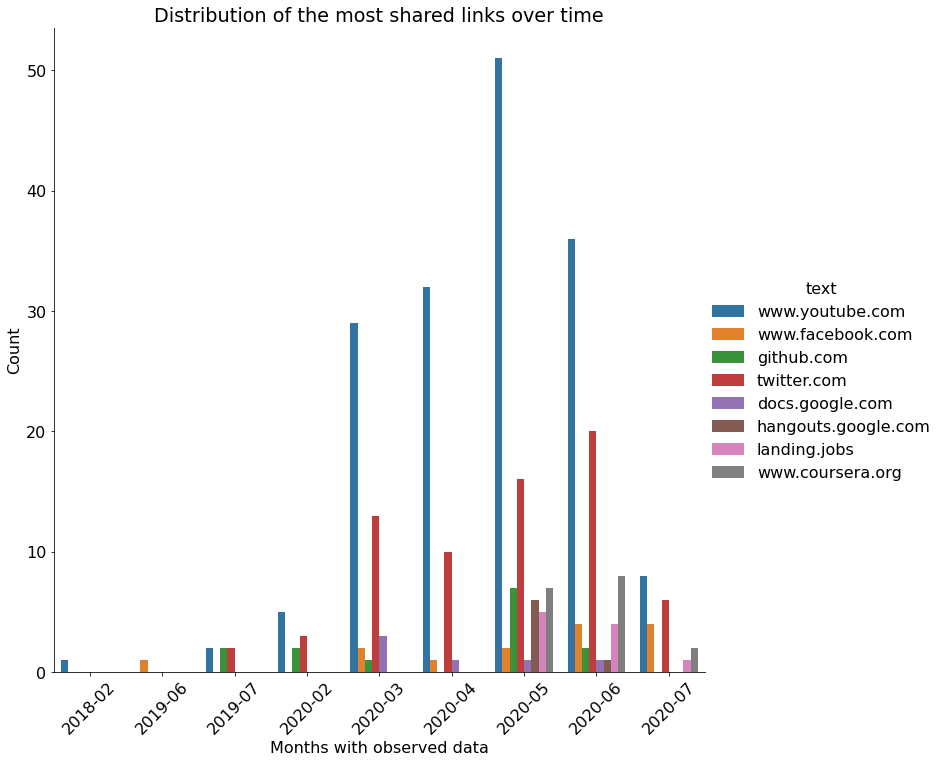

In [45]:
g = sns.catplot(x="month", hue="text",
                data=show_links_df, kind="count",
                height=10,orient='h')
g.set_xticklabels(rotation=45)
g.set(xlabel="Months with observed data", ylabel = "Count")
plt.title('Distribution of the most shared links over time');

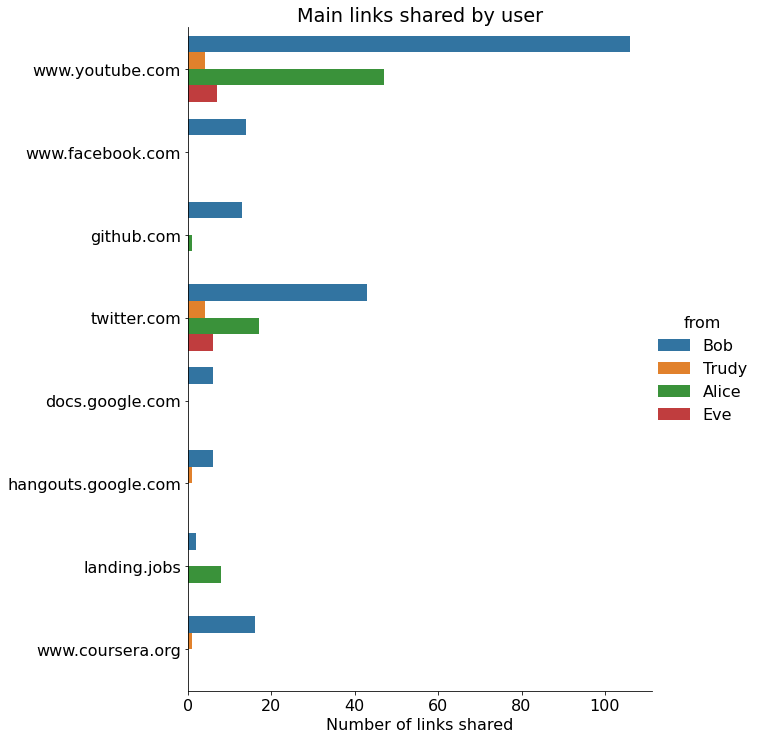

In [46]:
g = sns.catplot(y="text", hue="from",
                data=show_links_df, kind="count",
                height=10,orient='h')
g.set(xlabel="Number of links shared", ylabel = "")
plt.title('Main links shared by user');

##### But what does the actual data look like? 

In [47]:
# 15 most shared urls
links_df['text'].value_counts()[:15]

www.youtube.com          164
twitter.com               70
www.coursera.org          17
www.facebook.com          14
github.com                14
landing.jobs              10
hangouts.google.com        7
docs.google.com            6
www.infobae.com            6
vm.tiktok.com              6
www.worldometers.info      6
careers.google.com         5
www.udemy.com              5
www.instagram.com          4
i.imgur.com                4
Name: text, dtype: int64

#### So.. most of the links are to youtube and Bob's the one sending them

##### Coming back to the individual messages, let's look into the increase in activity

In [48]:
# Let's apply some advanced data cleaning techniques
# drop msgs from bot
message_df=text_df
message_df.drop(message_df[message_df['from']== 'bot'].index,inplace=True)
message_df.drop(message_df[message_df['from']== 'Book Download Bot'].index,inplace=True)

In [49]:
## We'll be generating a dictionary to separate and clean all the text per user
message_df['text'].replace('', np.nan, inplace=True) # replace empty strings with NaN
message_df.dropna(subset=['text'], inplace=True) #drop NaN
message_dict={}
for usr in ['Trudy', 'Alice', 'Bob', 'Eve']:
    message_dict[usr]= message_df.loc[message_df['from']==usr]['text']

In [50]:
messages_flat = {key: [utils.flatten(value)] for (key, value) in message_dict.items()}
#https://github.com/adashofdata/nlp-in-python-tutorial
pd.set_option('max_colwidth',140)
clean_msg_df= pd.DataFrame.from_dict(messages_flat).transpose()
clean_msg_df.columns = ['text']
clean_msg_df = clean_msg_df.sort_index()

In [51]:
texts_clean_df = pd.DataFrame(clean_msg_df.text.apply(utils.clean_text_round1))
texts_clean_df = pd.DataFrame(texts_clean_df.text.apply(utils.clean_text_round2))
texts_clean_df = pd.DataFrame(texts_clean_df.text.apply(utils.stem_lol))

In [52]:
# creating and storing a document-term matrix
cv = CountVectorizer(stop_words=stopwords)
data_cv = cv.fit_transform(texts_clean_df.text)
texts_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
texts_dtm.index = texts_clean_df.index
texts_dtm.to_pickle("texts_dtm.pkl")

In [53]:
texts_dtm=texts_dtm.transpose()
texts_dtm.head()

,Alice,Bob,Eve,Trudy
aaa,0,1,0,2
aaaaa,0,1,0,0
aaaaaaaaa,1,0,0,0
aaaaaaaaaa,0,1,0,0
aaaaaaaaah,0,1,0,0


In [54]:
#top 30 words said by each user
top_dict = {}
for c in texts_dtm.columns:
    top = texts_dtm[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

In [55]:
#if a word is said a lot by 3 or 4 group members, add it to stopwords
words2 = []
for user in texts_dtm.columns:
    top = [word for (word, count) in top_dict[user]]
    for t in top:
        words2.append(t)
add_stop_words = [word for word, count in collections.Counter(words2).most_common() if count > 2]
stopwords+=add_stop_words

In [56]:
#refactoring the Document-Term Matrix with the newly updated stopwords list
cv = CountVectorizer(stop_words=stopwords)
data_cv = cv.fit_transform(texts_clean_df.text)
texts_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
texts_dtm.index = texts_clean_df.index
#texts_dtm.to_pickle("texts_dtm.pkl")

In [57]:
wc2 = WordCloud(width = 1200, height = 800,
                min_font_size=10,max_words=400,
                stopwords=stopwords,background_color="black",
                colormap="viridis",
                max_font_size=150, random_state=42)

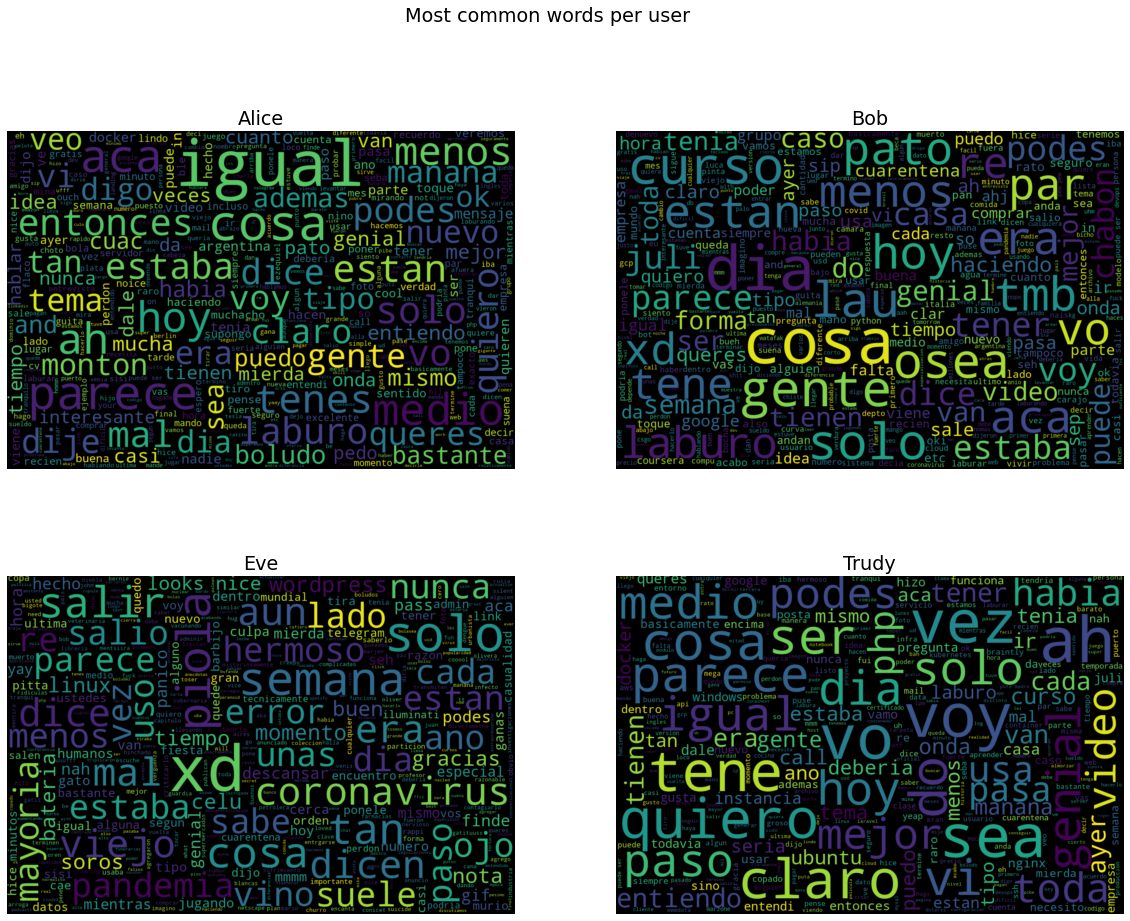

In [58]:
plt.rcParams['figure.figsize'] = [20, 15]
titles = ['Alice', 'Bob', 'Eve', 'Trudy']
# Create subplots for each user
for index, user in enumerate(texts_dtm.index):
    wc2.generate(texts_clean_df.text[user])
    plt.subplot(2, 2, index+1)
    plt.imshow(wc2, interpolation="bilinear")
    plt.axis("off")
    plt.subplots_adjust()
    plt.title(titles[index])
plt.suptitle('Most common words per user');
plt.show()

###### This shows a different story than the WordCloud we previously plotted, now that we've separated each user's words

#### Finding the vocabulary size for each user

In [59]:
# Identify the non-zero items in the DTM, meaning that the word occurs at least once
texts_dtm=texts_dtm.transpose()
unique_list = []
for user in texts_dtm.columns:
    uniques = texts_dtm[user].to_numpy().nonzero()[0].size
    unique_list.append(uniques)

# Create a new dataframe that contains this unique word count
data_words = pd.DataFrame(list(zip(titles, unique_list)), columns=['user', 'unique_words'])
data_unique_sort = data_words.sort_values(by='unique_words')

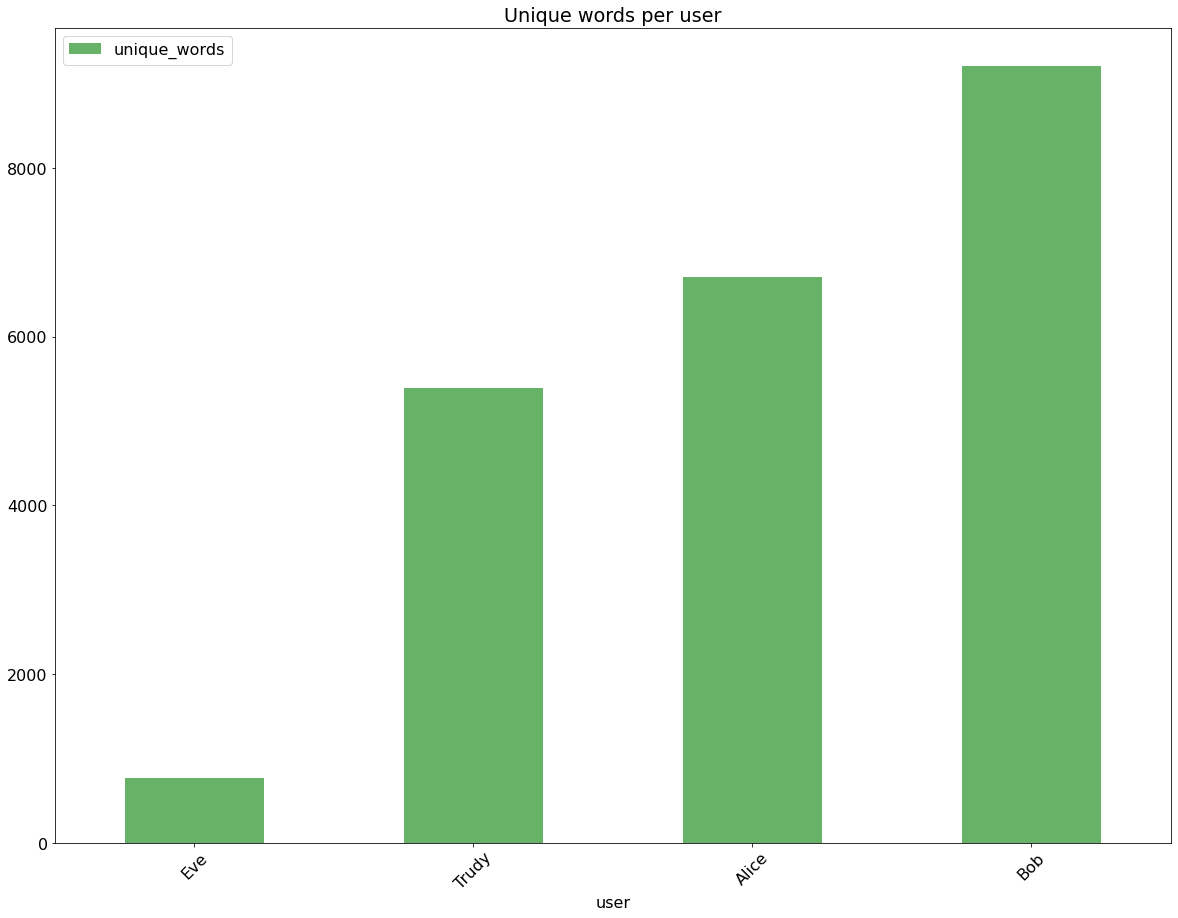

In [60]:
data_unique_sort.plot.bar(x='user',y='unique_words',color='g',alpha=0.6)
plt.rcParams['figure.figsize'] = [5, 5]
plt.title('Unique words per user')
plt.xticks(rotation=45)
plt.legend(loc='upper left');

In [61]:
pat = r'\b(?:{})\b'.format('|'.join(stopwords))
clean_df= message_df
clean_df['text']= clean_df['text'].apply(utils.clean_msg)
clean_df['text']= clean_df['text'].str.replace(pat, '').str.replace(r'\s+', ' ')
clean_df['text'].replace('', np.nan, inplace=True) # replace empty strings with NaN
clean_df.dropna(subset=['text'], inplace=True) #drop NaN
clean_df=clean_df.drop(clean_df[ clean_df['text'].str.isspace()].index) #drop spaces
clean_df['date'] = pd.to_datetime(clean_df['date'], utc=True)
clean_df['weekDay']= clean_df['date'].dt.day_name()

###### I'm intrigued by the group's activity

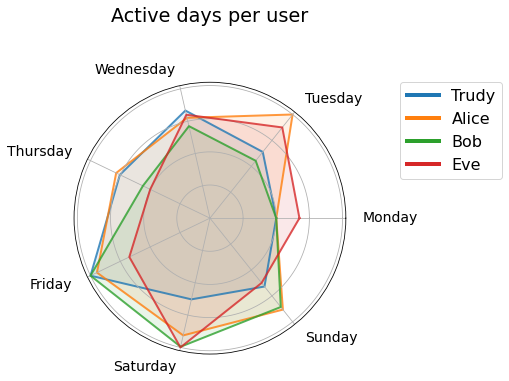

In [62]:
utils.plot_day_spider(clean_df,savefig=False, dpi=100)

###### Looks like Mondays are hard and the group tends to become more active towards the weekend

##### Remember Bob's passion for responding to messages with a single 😂 emoji? Let's track it's use over time... see what happens

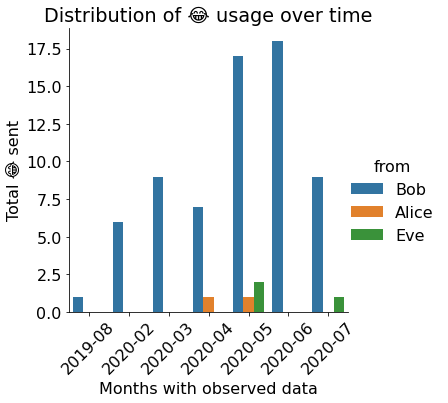

In [63]:
bobsEmoji_df=user_msg_df[user_msg_df['text'].str.contains("😂")]

g = sns.catplot(x="month", hue="from",
                data=bobsEmoji_df, kind="count",
                height=5,orient='h')
g.set_xticklabels(rotation=45)
g.set(xlabel="Months with observed data", ylabel = "Total 😂 sent")
plt.title('Distribution of 😂 usage over time');


#### What about the most common word: `jajaja` ?

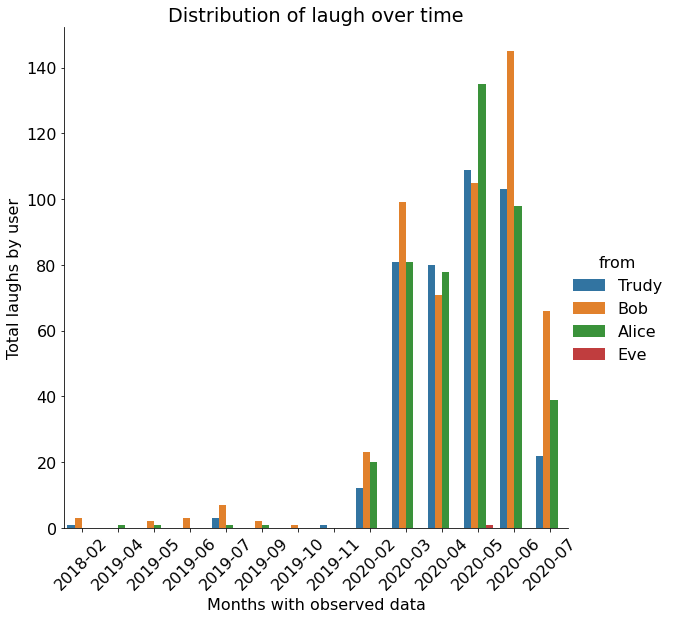

In [64]:
catFace_df= user_msg_df[user_msg_df['text'].str.contains("jajaja")]

g = sns.catplot(x="month", hue="from",
                data=catFace_df, kind="count",
                height=8,orient='h')
g.set_xticklabels(rotation=45)
g.set(xlabel="Months with observed data", ylabel = "Total laughs by user")
plt.title('Distribution of laugh over time');

#### This was to be expected, since under lockdown we try to cheer each other up... let's track the use of the word. Apparently, Bob was a bit worried about this subject when the pandemic hit the Western Hemisphere back in March 2020

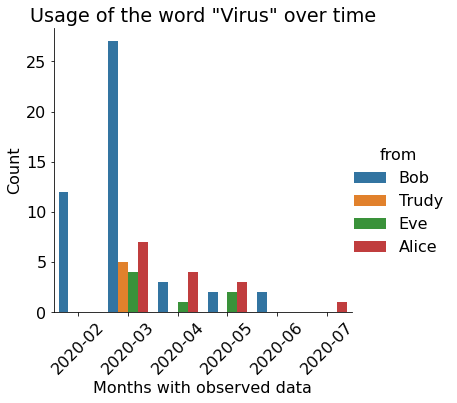

In [65]:
catFace_df= user_msg_df[user_msg_df['text'].str.contains("virus")]

g = sns.catplot(x="month", hue="from",
                data=catFace_df, kind="count",
                height=5,orient='h')
g.set_xticklabels(rotation=45)
g.set(xlabel="Months with observed data", ylabel = "Count")
plt.title('Usage of the word "Virus" over time');

#### This shows that the word `Virus` was not used before the pandemic. It had a spike back in March, when everyone on the group was talking about it. Inspite the fact that Bob was the user who most talked about it, eventually he stopped using it.

In [66]:
catFace_df['month']=catFace_df['date'].dt.to_period("M")
vir_count=catFace_df.groupby(['from', 'month'],
                as_index=False).agg('count')[['from','date','month']]
msgs_corr_df= user_msg_df.groupby(['from', 'month'],as_index=False).agg('count')
tot_msg_corr=msgs_corr_df[msgs_corr_df['month'].isin(vir_count['month'].unique())][['from','date','month']]

#vir_count.rename(columns={'date': 'date_vir', 'month': 'month_vir'}, inplace=True)
vir_count=vir_count.groupby(['month'],as_index=False).agg('sum')
tot_msg_corr=tot_msg_corr.groupby(['month'],as_index=False).agg('sum')

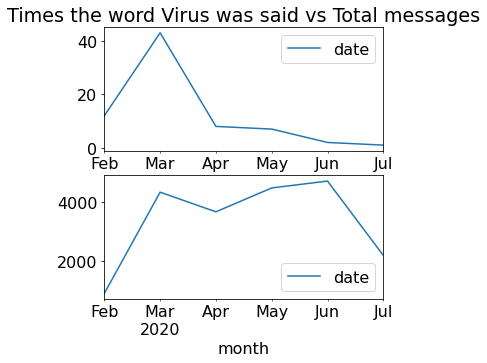

In [67]:
fig = plt.figure()
# Divide the figure into a 1x2 grid, and give me the first section
ax1 = fig.add_subplot(211)
vir_count.plot(ax=ax1,x='month',y='date',title='Times the word Virus was said vs Total messages')
# Divide the figure into a 1x2 grid, and give me the second section
ax2 = fig.add_subplot(212)
tot_msg_corr.plot(ax=ax2,x='month',y='date');

###### It appears in February there was a positive correlation between the increase in messages and the appearence of the word Virus, but it was not sustained.

In [68]:
#TODO:
# fix emojis and spelling
# move graphs to functions in utils.py
# topic modeling
# sentiment analysis
# perhaps try to train an AI using those 22k messages as the corpus
# see if there are bursts of messages across time